# Machine Learning Assignment Project: Taxi Duration in New York City Prediction - A Comprehensive Analysis with Machine Learning Techniques

In [2]:
# Import libraries
import os, shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

## Import dataset

In [15]:
# Check kaggle if it's available
!kaggle --version

Kaggle API 1.7.4.5


### Download dataset from kaggle

In [ ]:
#!kaggle competitions download -c nyc-taxi-trip-duration -p ./data

 78%|██████████████████████████████▍        | 67.0M/85.8M [00:00<00:00, 232MB/s]
100%|███████████████████████████████████████| 85.8M/85.8M [00:00<00:00, 228MB/s]


### Unzip files

In [18]:
# Unzip the downloaded file
def unzip_file(zip_src, dst_dir, delete=False):
    if os.path.exists(zip_src) and zip_src.endswith(".zip"):
        with zipfile.ZipFile(zip_src, 'r') as zf:
            zf.extractall(dst_dir)
    else:
        print(f"The address of file is {zip_src}, which isn't support upzipping.")
        return
        
    # remove the zip file after extraction
    if delete:
        os.remove(zip_src)
        print(f"Deleted: {zip_src}")

#### Unzipping parent directory

In [19]:
data_dir = "./data"
zip_name = "nyc-taxi-trip-duration.zip" 
unzip_file(os.path.join(data_dir, zip_name), data_dir, True)
!ls ./data

Deleted: ./data/nyc-taxi-trip-duration.zip
sample_submission.zip  test.zip  titanic_old  train.zip


#### Unzipping main files

In [20]:
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if os.path.isfile(file_path) and filename.endswith(".zip") and filename != "sample_submission.zip":
        unzip_file(file_path, data_dir, delete=True)

Deleted: ./data/test.zip
Deleted: ./data/train.zip


In [21]:
!ls ./data

sample_submission.zip  test.csv  titanic_old  train.csv


### Load dataset into DataFrame

In [22]:
df = pd.read_csv("./data/train.csv")

print(df.shape)
print(df.info())
print(df.isnull().sum())
df.head(5)

(1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude     

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


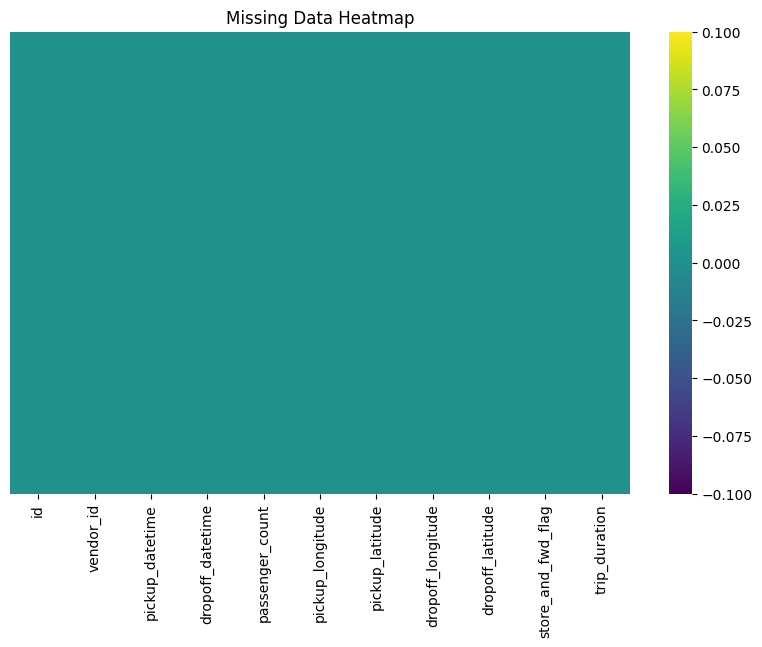

In [23]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

Our dataset isn't contain any null values, so we can proceed with our analysis.

## Preprocessing data

### Define the haversine distance function

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6378.137 # Earth radius in kilometres
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

In [33]:
def distance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add Haversine distance (km) between pickup and dropoff to the DataFrame.
    """
    df['distance_km'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )

    return df

### Define feature engineering functions

In [45]:
def feature_engineering(df):
    """Enhanced feature engineering with time, distance, and geospatial insights"""
    df = df.copy()

    # Time
    pickup_datetime = pd.to_datetime(df['pickup_datetime'])
    df['pickup_year'] = pickup_datetime.dt.year
    df['pickup_month'] = pickup_datetime.dt.month
    df['pickup_day'] = pickup_datetime.dt.day
    df['pickup_hour'] = pickup_datetime.dt.hour
    df['pickup_minute'] = pickup_datetime.dt.minute
    df['pickup_weekday'] = pickup_datetime.dt.weekday
    df['pickup_yday'] = pickup_datetime.dt.dayofyear
    df['pickup_weekend'] = (pickup_datetime.dt.weekday >= 5).astype(int)

    # Time category
    df['is_rush_hour'] = (((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 9)) |
                          ((df['pickup_hour'] >= 17) & (df['pickup_hour'] <= 19))).astype(int)
    df['is_night'] = ((df['pickup_hour'] >= 22) | (df['pickup_hour'] <= 5)).astype(int)

    # Calculate the distance with Haversine fomula
    df['distance_km'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )

    df['direction'] = np.degrees(np.arctan2(
        (df['dropoff_latitude'] - df['pickup_latitude']),
        (df['dropoff_longitude'] - df['pickup_longitude'])
    ))

    # Center coordinates
    df['center_latitude'] = (df['pickup_latitude'] + df['dropoff_latitude']) / 2
    df['center_longitude'] = (df['pickup_longitude'] + df['dropoff_longitude']) / 2

    # Binary categorical
    df['store_and_fwd_flag'] = (df['store_and_fwd_flag'] == 'Y').astype(int)

    return df


### Clean data formatting and outlier removal

In [48]:
def clean_data(df):
    df = df.copy()

    print(f"Initial shape: {df.shape}")

    if 'trip_duration' in df.columns:
        df = df[(df['trip_duration'] > 30) & (df['trip_duration'] < 3600 * 6)]
        print(f"After duration filter: {df.shape}")

    # Remove zero-distance trips
    df = df[df['distance_km'] > 0]
    print(f"After distance filter: {df.shape}")

    # Geographic bounding box
    bounds = {'min_lat': 40.5, 'max_lat': 41.0, 'min_lon': -74.3, 'max_lon': -73.7}
    df = df[
        (df['pickup_latitude'].between(bounds['min_lat'], bounds['max_lat'])) &
        (df['pickup_longitude'].between(bounds['min_lon'], bounds['max_lon'])) &
        (df['dropoff_latitude'].between(bounds['min_lat'], bounds['max_lat'])) &
        (df['dropoff_longitude'].between(bounds['min_lon'], bounds['max_lon']))
    ]

    print(f"After geographic filter: {df.shape}")
    return df

### Preprocessing function

In [49]:
def preprocessing(df: pd.DataFrame, scale=True, random_state=42) -> tuple:
    print("Starting preprocessing data...")
    
    # Geospatial feature engineering
    df = feature_engineering(df)
    
    # Data cleaning
    df = clean_data(df)

    # Target transformation
    y = np.log1p(df['trip_duration'])  # log-transform to handle skewness

    # Drop unused columns
    drop_cols = ['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration']
    X = df.drop(columns=[c for c in drop_cols if c in df.columns])
    

    # Split dataset into train, test, val sets with the ratio: ()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

    # Feature scaling
    scaler = None
    if scale:
        numerical_cols = [
            'vendor_id', 'passenger_count',
            'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'pickup_hour', 'pickup_weekday', 'pickup_month',
            'distance_km', 'direction',
            'center_latitude', 'center_longitude'
        ]

        # Only scale columns that exist
        numerical_cols = [col for col in numerical_cols if col in X_train.columns]

        scaler = StandardScaler()
        X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
        X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print("Preprocessing completed.")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

## Apply preprocessing function to the dataset

In [50]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocessing(df)

Starting preprocessing data...
Initial shape: (1458644, 26)
After duration filter: (1451693, 26)
After distance filter: (1447148, 26)
After geographic filter: (1446308, 26)
Preprocessing completed.
Train: (1157046, 22), Val: (144631, 22), Test: (144631, 22)


In [51]:
# Show first 5 rows of processed training data
print("Processed training features:")
print(X_train.head())

print("\nProcessed training target:")
print(y_train.head())

Processed training features:
         vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
639188    0.933769        -0.505563          0.524444         1.105149   
368146    0.933769         1.016558         -0.959225        -1.625605   
855622   -1.070929        -0.505563         -0.043205         0.179363   
1151270  -1.070929        -0.505563         -0.232286        -0.044750   
173902    0.933769        -0.505563         -0.323483         0.401694   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_hour  \
639188           -0.131055          0.458424                   0     0.928331   
368146           -0.063123         -0.678279                   0     0.928331   
855622           -0.276625          0.096165                   0    -0.282274   
1151270           0.216107          1.653890                   0     0.582444   
173902           -0.552987         -0.474157                   0    -1.319935   

         pickup_dayofweek  pickup_month

### Visualize key distributions and correlations after preprocessing

In [52]:
def visualize_processed_data(X_train, y_train):
    # Reverse log-transform for interpretation
    trip_duration_original = np.expm1(y_train)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Trip duration distribution
    sns.histplot(trip_duration_original, bins=50, kde=True, color='teal', ax=axes[0, 0])
    axes[0, 0].set_title("Distribution of Trip Duration (seconds)")
    axes[0, 0].set_xlabel("Trip Duration (s)")
    axes[0, 0].set_ylabel("Frequency")

    # Distance distribution
    if 'distance_km' in X_train.columns:
        sns.histplot(X_train['distance_km'], bins=50, kde=True, color='orange', ax=axes[0, 1])
        axes[0, 1].set_title("Distribution of Trip Distance (km)")
        axes[0, 1].set_xlabel("Distance (km)")
        axes[0, 1].set_ylabel("Frequency")

    # Trip duration by pickup hour
    if 'pickup_hour' in X_train.columns:
        sns.boxplot(x=X_train['pickup_hour'], y=trip_duration_original, ax=axes[1, 0], color='lightblue')
        axes[1, 0].set_title("Trip Duration by Pickup Hour")
        axes[1, 0].set_xlabel("Hour of Day")
        axes[1, 0].set_ylabel("Trip Duration (s)")

    # Correlation heatmap
    corr = X_train.corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, ax=axes[1, 1])
    axes[1, 1].set_title("Feature Correlation Heatmap")

    plt.show()

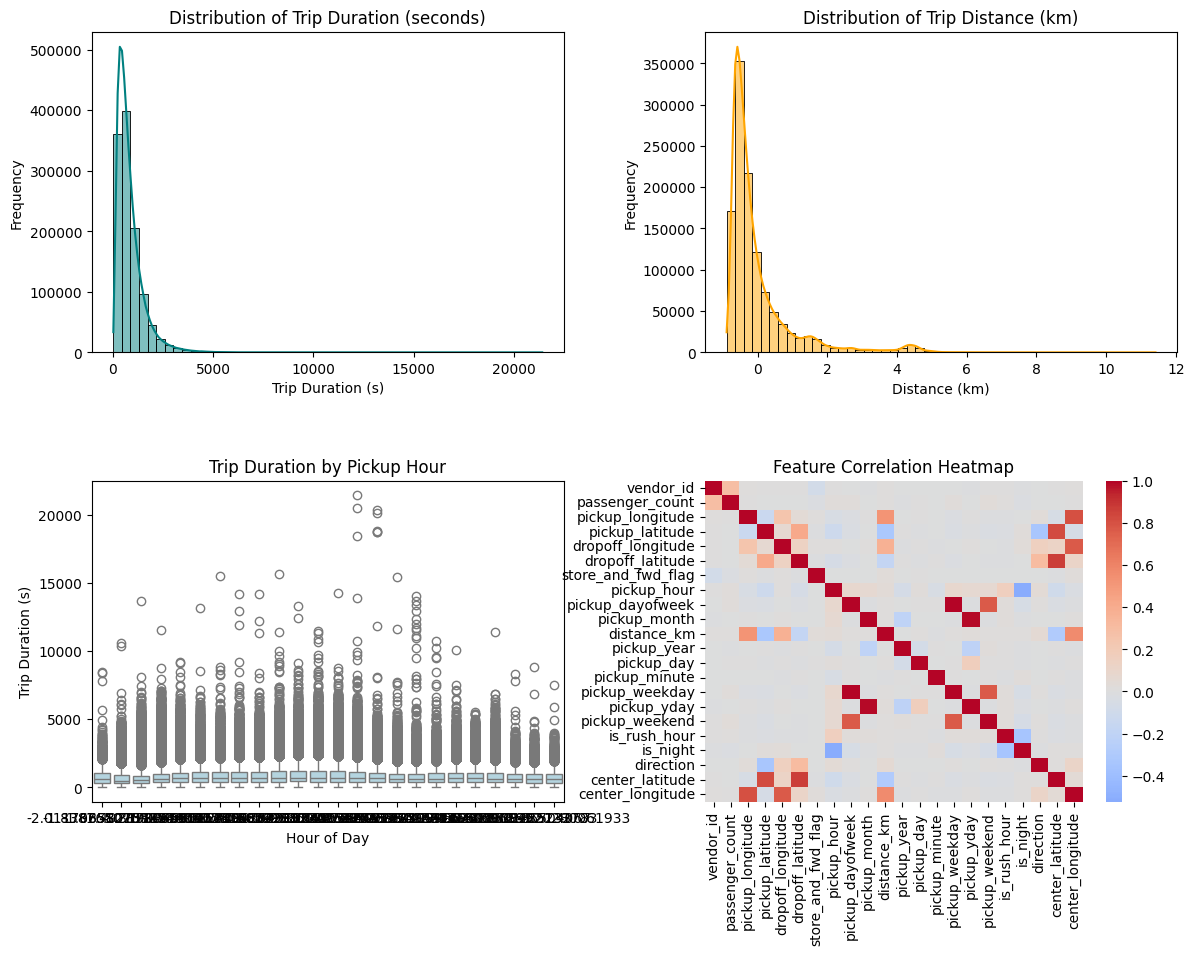

In [53]:
visualize_processed_data(X_train, y_train)